In [1]:
import torch
import pathlib
from models.graph_learning import HiPoNet, MLPAutoEncoder
from utils.read_data import load_data
import phate
import scprep

In [2]:
slurm_job_id = "1779231"
weights_loc = pathlib.Path(f"model_weights/{slurm_job_id}")

In [3]:
device = "cpu"
PC_gene, PC_spatial, labels = load_data("data/sea", "")
model_spatial = (
    HiPoNet(
        dimension=PC_spatial[0].shape[1],
        n_weights=1,
        threshold=0.15,
        K=1,
        J=3,
        device="cpu",
        sigma=10,
        pooling=False,
    )
    .to(device)
    .float()
)
model_gene = (
    HiPoNet(
        dimension=PC_gene[0].shape[1],
        n_weights=1,
        threshold=0.15,
        K=1,
        J=3,
        device="cpu",
        sigma=10,
        pooling=False,
    )
    .to(device)
    .float()
)
with torch.no_grad():
    input_dim = (
        model_spatial(
            PC_spatial[0][:5].unsqueeze(0).to(device),
            torch.zeros((1, 5), dtype=torch.bool).to(device),
        ).shape[1]
        + model_gene(
            PC_gene[0][:5].unsqueeze(0).to(device),
            torch.zeros((1, 5), dtype=torch.bool).to(device),
        ).shape[1]
    )
autoencoder = MLPAutoEncoder(
    input_dim, 256, 4, 3, bn=False
)

In [4]:
train_test_split = torch.load(weights_loc / "split_idx.pt")
(
    autoencoder.load_state_dict(
        torch.load(weights_loc / "autoenc.pt", map_location=device)
    ),
    model_gene.load_state_dict(
        torch.load(weights_loc / "model_gene.pt", map_location=device)
    ),
    model_spatial.load_state_dict(
        torch.load(weights_loc / "model_spatial.pt", map_location=device)
    ),
)

(<All keys matched successfully>,
 <All keys matched successfully>,
 <All keys matched successfully>)

In [5]:
selected_index = 3
pc_gene, pc_spatial, cell_types = PC_gene[selected_index].unsqueeze(0), PC_spatial[selected_index].unsqueeze(0), labels[selected_index]
mask = torch.ones(pc_gene.shape[:2], dtype=torch.bool)

with torch.no_grad():
    X_spatial, X_gene = model_gene(pc_gene, mask), model_spatial(pc_spatial, mask)

    X = torch.cat([X_spatial, X_gene], 1)
    embedding = autoencoder.encode(X)
    reconstructed = autoencoder.forward(X)
embedding.shape

torch.Size([5333, 4])

In [6]:
phate_dim = 2
phate_knn = 5

# PHATE on reconstructed outputs

In [12]:
torch.nn.functional.mse_loss(X, reconstructed)

tensor(7.6272e-06)

Calculating PHATE...
  Running PHATE on 5333 observations and 1274 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.81 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.21 seconds.
    Calculating affinities...
    Calculated affinities in 1.75 seconds.
  Calculated graph and diffusion operator in 2.77 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.22 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.32 seconds.
  Calculated landmark operator in 3.55 seconds.
  Calculating optimal t...
    Automatically selected t = 46
  Calculated optimal t in 2.95 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.26 seconds.
Calculated PHATE in 15.16 seconds.


Exception: Stop

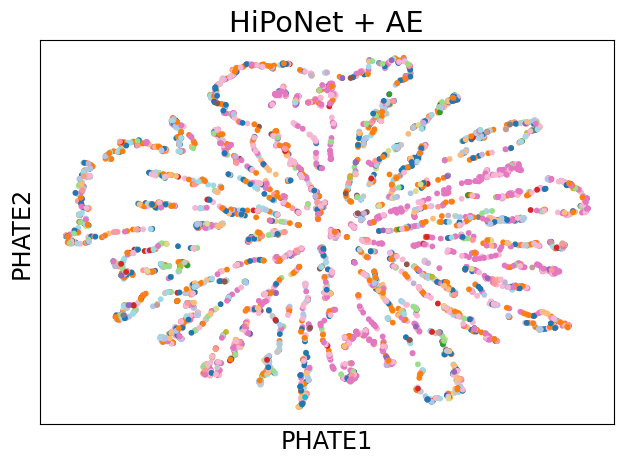

In [7]:
phate_op = phate.PHATE(n_components=phate_dim, knn=phate_knn)
phate_coords = phate_op.fit_transform(reconstructed)

scprep.plot.scatter2d(
    phate_coords,
    c=cell_types,
    cmap="tab20",
    s=10,
    # figsize=(15,10),
    ticks=None,
    label_prefix="PHATE",
    fontsize=12,
    legend=False,
    title="HiPoNet + AE",
)
raise Exception("Stop")

# Phate on AutoEncoder embeddings

<Axes: title={'center': 'HiPoNet + AE'}, xlabel='PHATE1', ylabel='PHATE2'>

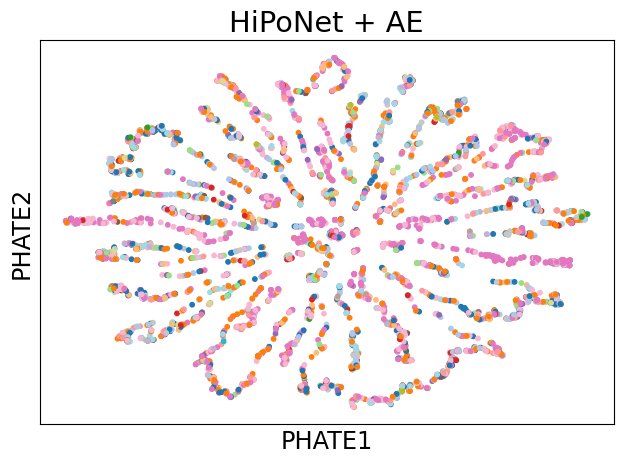

In [ ]:
phate_op = phate.PHATE(n_components=phate_dim, knn=phate_knn)
phate_coords = phate_op.fit_transform(embedding)

scprep.plot.scatter2d(
    phate_coords,
    c=cell_types,
    cmap="tab20",
    s=10,
    # figsize=(15,10),
    ticks=None,
    label_prefix="PHATE",
    fontsize=12,
    legend=False,
    title="HiPoNet + AE",
)

# Directly on Gene Expression data

Calculating PHATE...
  Running PHATE on 5333 observations and 180 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.34 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.50 seconds.
    Calculating affinities...
    Calculated affinities in 0.26 seconds.
  Calculated graph and diffusion operator in 1.12 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.70 seconds.
    Calculating KMeans...
    Calculated KMeans in 4.05 seconds.
  Calculated landmark operator in 4.75 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 2.26 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.12 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.25 seconds.
Calculated PHATE in 11.87 seconds.


<Axes: title={'center': 'PHATE on gene expression data'}, xlabel='PHATE1', ylabel='PHATE2'>

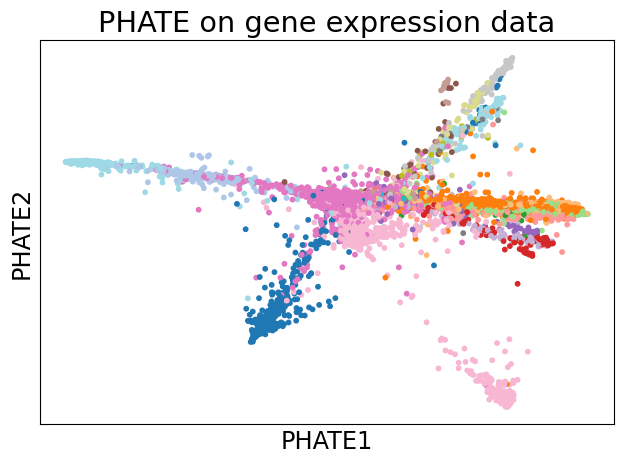

In [ ]:
phate_op = phate.PHATE(n_components=phate_dim, knn=phate_knn)
phate_coords = phate_op.fit_transform(pc_gene.squeeze())

scprep.plot.scatter2d(
    phate_coords,
    c=cell_types,
    cmap="tab20",
    s=10,
    # figsize=(15,10),
    ticks=None,
    label_prefix="PHATE",
    fontsize=12,
    legend=False,
    title="PHATE on gene expression data",
)

# Just HipoNet (pre-embedding)

Calculating PHATE...
  Running PHATE on 5333 observations and 1274 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.73 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.26 seconds.
    Calculating affinities...
    Calculated affinities in 1.68 seconds.
  Calculated graph and diffusion operator in 2.68 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.29 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.13 seconds.
  Calculated landmark operator in 3.42 seconds.
  Calculating optimal t...
    Automatically selected t = 30
  Calculated optimal t in 3.60 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.15 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.58 seconds.
Calculated PHATE in 15.79 seconds.


<Axes: title={'center': 'HiPoNet'}, xlabel='PHATE1', ylabel='PHATE2'>

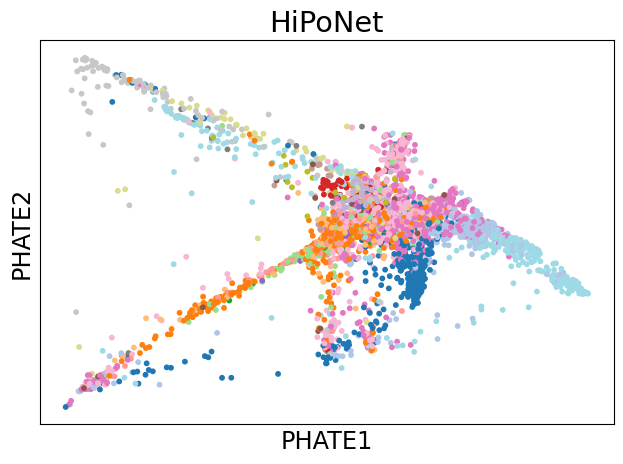

In [ ]:
phate_op = phate.PHATE(n_components=phate_dim, knn=phate_knn)
phate_coords = phate_op.fit_transform(X.squeeze())

scprep.plot.scatter2d(
    phate_coords,
    c=cell_types,
    cmap="tab20",
    s=10,
    # figsize=(15,10),
    ticks=None,
    label_prefix="PHATE",
    fontsize=12,
    legend=False,
    title="HiPoNet",
)